In [117]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay

In [118]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions in `welcome_to_FE55.ipynb`.

In [119]:
import eups
assert eups.getSetupVersion("obs_lsst")

In [120]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

In [121]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'})

In [143]:
dId = {'visit': visits[50], 'detector': 2}
raw = butler.get('raw', **dId)

In [327]:
detector.getName()

'R00_S02'

In [144]:
detector = raw.getDetector()

In [145]:
afw_display.mtv(raw)

In [146]:
# for the geometry we've chosen, the y=0 amps are in the top
# Normally the read corner would tell you this, but there is currently a bug
flipXY = {'C00':(False, True),
          'C01':(False, True),
          'C02':(False, True),
          'C03':(False, True),
          'C04':(False, True),
          'C05':(False, True),
          'C06':(False, True),
          'C07':(False, True),
          'C10':(True, False),
          'C11':(True, False),
          'C12':(True, False),
          'C13':(True, False),
          'C14':(True, False),
          'C15':(True, False),
          'C16':(True, False),
          'C17':(True, False)
         }

In [147]:
overscans = {}

for key, value in flipXY.items():
    bbox = detector[key].getRawHorizontalOverscanBBox()
    overscans[key] = raw[bbox].getMaskedImage().getImage().clone() # since these are views into the pixels, we want a copy so we don't mess with the pixels in the original image    

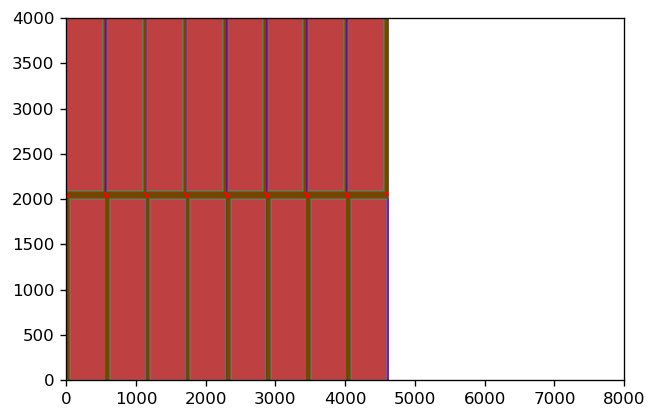

In [148]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots() 
ax.set_xlim(0,8000)
ax.set_ylim(0,4000)

chips = ['C00','C01','C02','C03','C04','C05','C06','C07','C10','C11','C12','C13','C14','C15','C16','C17']

for chip in [detector[chip_name] for chip_name in chips]:

    bbox = chip.getRawBBox()
    rectangle = Rectangle((bbox.getBeginX(), bbox.getBeginY()), bbox.getWidth(), bbox.getHeight(), fill=True, color='red', edgecolor='black')
    ax.add_artist(rectangle)
    
    bbox = chip.getRawPrescanBBox()
    rectangle = Rectangle((bbox.getBeginX(), bbox.getBeginY()), bbox.getWidth(), bbox.getHeight(), alpha=0.5, fill=True, color='blue')
    ax.add_artist(rectangle)
    
    bbox = chip.getRawHorizontalOverscanBBox()
    rectangle = Rectangle((bbox.getBeginX(), bbox.getBeginY()), bbox.getWidth(), bbox.getHeight(), alpha=0.5, fill=True, color='green')
    ax.add_artist(rectangle)
    
    bbox = chip.getRawVerticalOverscanBBox()
    rectangle = Rectangle((bbox.getBeginX(), bbox.getBeginY()), bbox.getWidth(), bbox.getHeight(), alpha=0.5, fill=True, color='green')
    ax.add_artist(rectangle)
    
    bbox = chip.getRawDataBBox()
    rectangle = Rectangle((bbox.getBeginX(), bbox.getBeginY()), bbox.getWidth(), bbox.getHeight(), alpha=0.5, fill=True, color='grey')
    ax.add_artist(rectangle)

In [149]:
overscans['C00'].getArray().shape

(2002, 54)

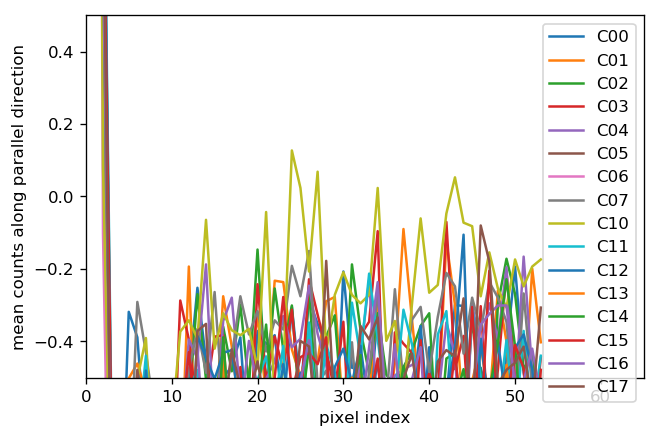

In [150]:
for channel_name, flips in flipXY.items():
    # get all the overscans in the same orientation and plot the mean along the y-axis
    arr = overscans[channel_name].getArray() # pull out numpy array
    oscan = numpy.mean(arr)
    fx, fy = flips
    if fx:
        arr = numpy.flip(arr, axis=1)
    if fy:
        arr = numpy.flip(arr, axis=0)
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    mean = numpy.mean(arr, axis=0)
    plt.plot(mean-oscan, label=channel_name)

plt.xlabel('pixel index')
plt.ylabel('mean counts along parallel direction')
plt.xlim(0, 65)
plt.ylim(-0.5, 0.5)
plt.legend()

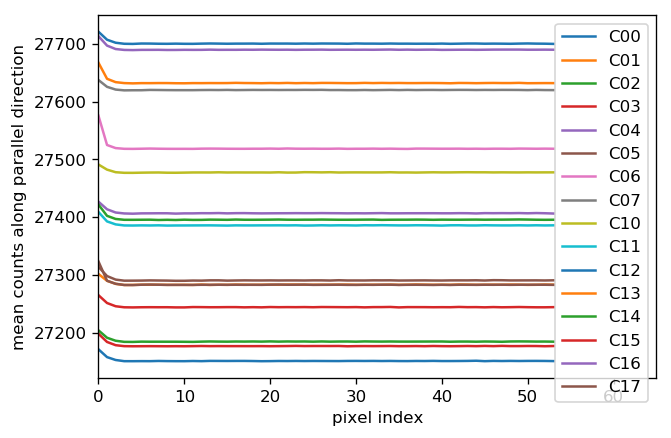

In [151]:
for channel_name, flips in flipXY.items():
    # get all the overscans in the same orientation and plot the mean along the y-axis
    arr = overscans[channel_name].getArray() # pull out numpy array
    oscan = numpy.mean(arr)
    fx, fy = flips
    if fx:
        arr = numpy.flip(arr, axis=1)
    if fy:
        arr = numpy.flip(arr, axis=0)
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    mean = numpy.mean(arr, axis=0)
    plt.plot(mean, label=channel_name)

plt.xlabel('pixel index')
plt.ylabel('mean counts along parallel direction')
plt.xlim(0, 65)
#plt.ylim(-0.5, 0.5)
plt.legend()

# Getting Horizontal CTE

In [152]:
detector['C10'].getRawBBox()

Box2I(minimum=Point2I(0, 0), dimensions=Extent2I(576, 2048))

In [153]:
detector['C10'].getRawHorizontalOverscanBBox()

Box2I(minimum=Point2I(0, 0), dimensions=Extent2I(54, 2002))

In [282]:
from lsst.geom import Point2I, Extent2I, Box2I

overscans2 = {}
OFFSET = 10
for key, value in flipXY.items():
    bbox = detector[key].getRawHorizontalOverscanBBox()
    if value[0]:
        point = Point2I(bbox.getMinX(), bbox.getMinY())
        ext = Extent2I(bbox.getWidth() + OFFSET, bbox.getHeight())
        new_bbox = Box2I(point, ext)
        overscans2[key] = raw[new_bbox].getMaskedImage().getImage().clone() # since these are views into the pixels, we want a copy so we don't mess with the pixels in the original image
        print(key, bbox, new_bbox)
    else:
        point = Point2I(bbox.getMinX() - OFFSET, bbox.getMinY())
        ext = Extent2I(bbox.getWidth() + OFFSET, bbox.getHeight())
        new_bbox = Box2I(point, ext)
        overscans2[key] = raw[new_bbox].getMaskedImage().getImage().clone() # since these are views into the pixels, we want a copy so we don't mess with the pixels in the original image
        print(key, bbox, new_bbox)

C00 (minimum=(522, 2094), maximum=(575, 4095)) (minimum=(512, 2094), maximum=(575, 4095))
C01 (minimum=(1098, 2094), maximum=(1151, 4095)) (minimum=(1088, 2094), maximum=(1151, 4095))
C02 (minimum=(1674, 2094), maximum=(1727, 4095)) (minimum=(1664, 2094), maximum=(1727, 4095))
C03 (minimum=(2250, 2094), maximum=(2303, 4095)) (minimum=(2240, 2094), maximum=(2303, 4095))
C04 (minimum=(2826, 2094), maximum=(2879, 4095)) (minimum=(2816, 2094), maximum=(2879, 4095))
C05 (minimum=(3402, 2094), maximum=(3455, 4095)) (minimum=(3392, 2094), maximum=(3455, 4095))
C06 (minimum=(3978, 2094), maximum=(4031, 4095)) (minimum=(3968, 2094), maximum=(4031, 4095))
C07 (minimum=(4554, 2094), maximum=(4607, 4095)) (minimum=(4544, 2094), maximum=(4607, 4095))
C10 (minimum=(0, 0), maximum=(53, 2001)) (minimum=(0, 0), maximum=(63, 2001))
C11 (minimum=(576, 0), maximum=(629, 2001)) (minimum=(576, 0), maximum=(639, 2001))
C12 (minimum=(1152, 0), maximum=(1205, 2001)) (minimum=(1152, 0), maximum=(1215, 2001))
C1

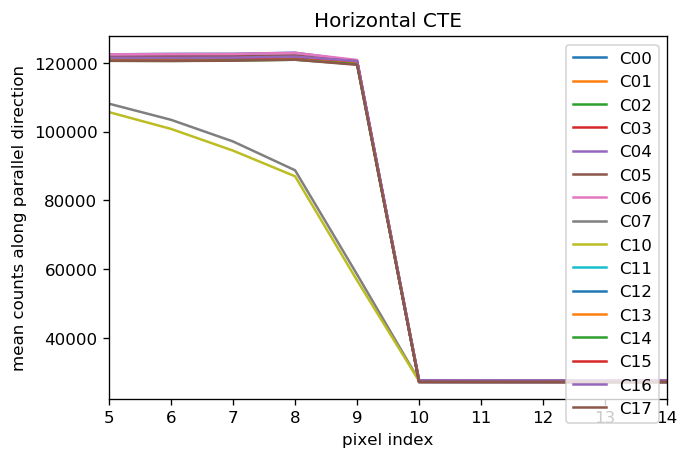

In [283]:
for channel_name, flips in flipXY.items():
    # get all the overscans in the same orientation and plot the mean along the y-axis
    arr = overscans2[channel_name].getArray() # pull out numpy array
    oscan = numpy.mean(arr)
    fx, fy = flips
    if fx:
        arr = numpy.flip(arr, axis=1)
    if fy:
        arr = numpy.flip(arr, axis=0)
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    mean = numpy.mean(arr, axis=0)
    plt.plot(mean, label=channel_name)

plt.title('Horizontal CTE')
plt.xlabel('pixel index')
plt.ylabel('mean counts along parallel direction')
plt.xlim(5, 14)
#plt.ylim(-0.5, 0.5)
plt.legend()

Are the CTEs correlated with row position?

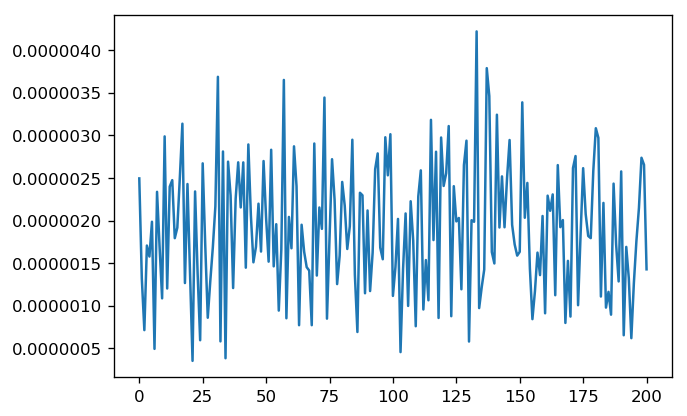

In [299]:
plt.plot(compute_CTE(overscans2['C00'].getArray())[::10],label='C00', color='blue')
plt.plot(compute_CTE(overscans2['C01'].getArray())[::10])
plt.plot(compute_CTE(overscans2['C02'].getArray())[::10])
plt.plot(compute_CTE(overscans2['C03'].getArray())[::10])
plt.legend()

plt.hist(compute_CTE(overscans2['C00'].getArray()), density=True, label='C00', color='blue', alpha=0.7);
plt.hist(compute_CTE(overscans2['C01'].getArray()), density=True, label='C01', color='red', alpha=0.7);
plt.hist(compute_CTE(overscans2['C02'].getArray()), density=True, label='C02', color='#d8567b', alpha=0.7);
plt.hist(compute_CTE(overscans2['C03'].getArray()), density=True, label='C03', color='#59c64f', alpha=0.7);

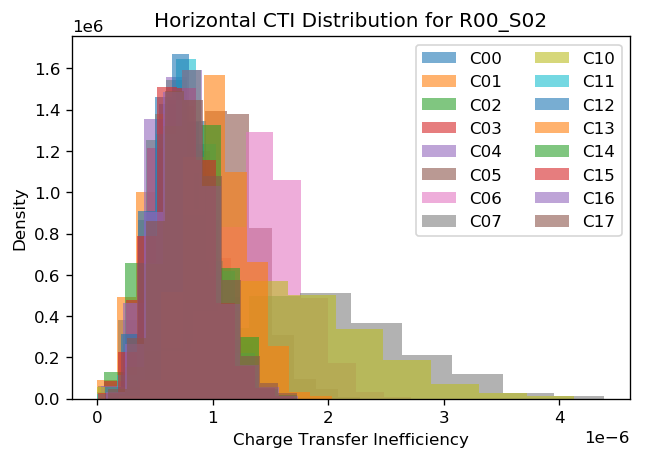

In [328]:
def compute_CTE(arr, amp='C00'):
    if 'C1' in amp:
        arr = numpy.flip(arr, axis=1)
    normed = numpy.maximum(arr - numpy.mean(arr[:,20:], axis=1).reshape(2002,1), 0)
    return numpy.sum(normed[:,10:14], axis=1) / normed[:,9] / 512


plt.title('Horizontal CTI Distribution for R00_S02')
for amp in ['C0{}'.format(i) for i in range(8)] + ['C1{}'.format(i) for i in range(8)]:
    plt.hist(compute_CTE(overscans2[amp].getArray(), amp=amp), density=True, label=amp, alpha=0.6);
# plt.hist(compute_CTE(overscans2['C01'].getArray()), density=True, label='C01', color='red', alpha=0.7);
# plt.hist(compute_CTE(overscans2['C02'].getArray()), density=True, label='C02', color='#d8567b', alpha=0.7);
# plt.hist(compute_CTE(overscans2['C03'].getArray()), density=True, label='C03', color='#59c64f', alpha=0.7);


plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.xlabel('Charge Transfer Inefficiency')
plt.ylabel('Density')
plt.legend(ncol=2);


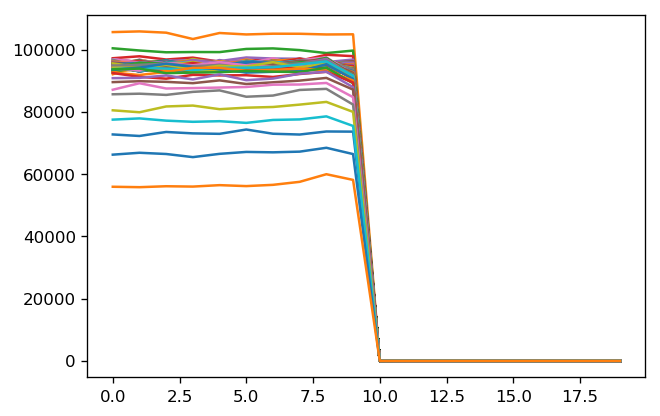

In [293]:
arr = overscans2['C00'].getArray()
normed = numpy.maximum(arr - numpy.mean(arr[:,20:], axis=1).reshape(2002,1), 1)
plt.plot(normed[:,0:20].T);

In [303]:
arr[500]

array([122408., 122684., 121785., 122494., 123313., 121442., 122374.,
       122730., 122845., 118866.,  27723.,  27698.,  27707.,  27704.,
        27705.,  27701.,  27700.,  27693.,  27706.,  27694.,  27691.,
        27694.,  27706.,  27708.,  27704.,  27699.,  27698.,  27697.,
        27698.,  27701.,  27704.,  27705.,  27693.,  27702.,  27704.,
        27706.,  27695.,  27698.,  27700.,  27691.,  27686.,  27695.,
        27704.,  27698.,  27714.,  27702.,  27701.,  27694.,  27702.,
        27699.,  27709.,  27714.,  27696.,  27711.,  27710.,  27700.,
        27715.,  27698.,  27693.,  27703.,  27697.,  27692.,  27711.,
        27706.], dtype=float32)

In [306]:
normed = arr - numpy.mean(arr[:,30:-1], axis=1).reshape(2002,1)
normed[500]

array([ 9.47067266e+04,  9.49827266e+04,  9.40837266e+04,  9.47927266e+04,
        9.56117266e+04,  9.37407266e+04,  9.46727266e+04,  9.50287266e+04,
        9.51437266e+04,  9.11647266e+04,  2.17265625e+01, -3.27343750e+00,
        5.72656250e+00,  2.72656250e+00,  3.72656250e+00, -2.73437500e-01,
       -1.27343750e+00, -8.27343750e+00,  4.72656250e+00, -7.27343750e+00,
       -1.02734375e+01, -7.27343750e+00,  4.72656250e+00,  6.72656250e+00,
        2.72656250e+00, -2.27343750e+00, -3.27343750e+00, -4.27343750e+00,
       -3.27343750e+00, -2.73437500e-01,  2.72656250e+00,  3.72656250e+00,
       -8.27343750e+00,  7.26562500e-01,  2.72656250e+00,  4.72656250e+00,
       -6.27343750e+00, -3.27343750e+00, -1.27343750e+00, -1.02734375e+01,
       -1.52734375e+01, -6.27343750e+00,  2.72656250e+00, -3.27343750e+00,
        1.27265625e+01,  7.26562500e-01, -2.73437500e-01, -7.27343750e+00,
        7.26562500e-01, -2.27343750e+00,  7.72656250e+00,  1.27265625e+01,
       -5.27343750e+00,  

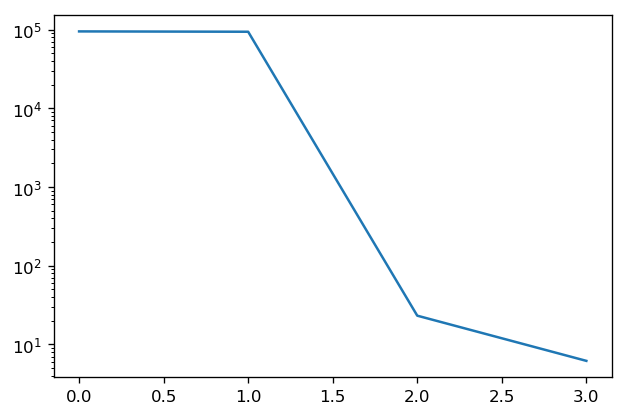

In [309]:
plt.plot(normed[501,8:12])
plt.gca().set_yscale('log')

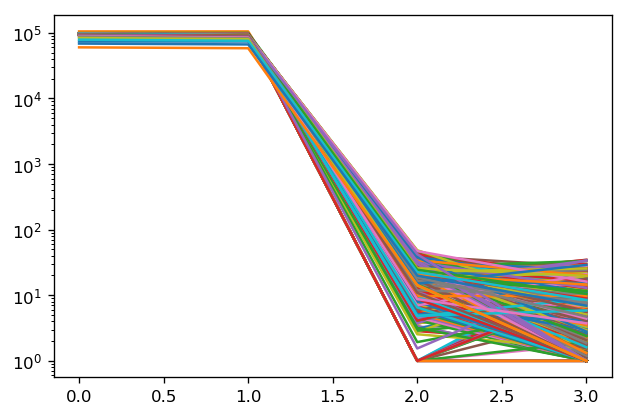

In [300]:
arr = overscans2['C00'].getArray()
normed = numpy.maximum(arr - numpy.mean(arr[:,20:], axis=1).reshape(2002,1), 1)
plt.plot(normed[:,8:12].T);
plt.gca().set_yscale('log')

# Getting Vertical CTE

In [51]:
detector['C10'].getRawBBox()

Box2I(minimum=Point2I(0, 0), dimensions=Extent2I(576, 2048))

In [52]:
detector['C10'].getRawVerticalOverscanBBox()

Box2I(minimum=Point2I(54, 2002), dimensions=Extent2I(512, 46))

In [60]:
overscans3 = {}

for key, value in flipXY.items():
    bbox = detector[key].getRawVerticalOverscanBBox()
    if value[0]:
        point = Point2I(bbox.getMinX(), bbox.getMinY())
        ext = Extent2I(bbox.getWidth(), bbox.getHeight()+ OFFSET)
        new_bbox = Box2I(point, ext)
        overscans3[key] = raw[new_bbox].getMaskedImage().getImage().clone() # since these are views into the pixels, we want a copy so we don't mess with the pixels in the original image
        print(key, bbox, new_bbox)
    else:
        point = Point2I(bbox.getMinX(), bbox.getMinY()- OFFSET)
        ext = Extent2I(bbox.getWidth(), bbox.getHeight()+ OFFSET)
        new_bbox = Box2I(point, ext)
        overscans3[key] = raw[new_bbox].getMaskedImage().getImage().clone() # since these are views into the pixels, we want a copy so we don't mess with the pixels in the original image
        print(key, bbox, new_bbox)

C00 (minimum=(10, 2048), maximum=(521, 2093)) (minimum=(10, 2038), maximum=(521, 2093))
C01 (minimum=(586, 2048), maximum=(1097, 2093)) (minimum=(586, 2038), maximum=(1097, 2093))
C02 (minimum=(1162, 2048), maximum=(1673, 2093)) (minimum=(1162, 2038), maximum=(1673, 2093))
C03 (minimum=(1738, 2048), maximum=(2249, 2093)) (minimum=(1738, 2038), maximum=(2249, 2093))
C04 (minimum=(2314, 2048), maximum=(2825, 2093)) (minimum=(2314, 2038), maximum=(2825, 2093))
C05 (minimum=(2890, 2048), maximum=(3401, 2093)) (minimum=(2890, 2038), maximum=(3401, 2093))
C06 (minimum=(3466, 2048), maximum=(3977, 2093)) (minimum=(3466, 2038), maximum=(3977, 2093))
C07 (minimum=(4042, 2048), maximum=(4553, 2093)) (minimum=(4042, 2038), maximum=(4553, 2093))
C10 (minimum=(54, 2002), maximum=(565, 2047)) (minimum=(54, 2002), maximum=(565, 2057))
C11 (minimum=(630, 2002), maximum=(1141, 2047)) (minimum=(630, 2002), maximum=(1141, 2057))
C12 (minimum=(1206, 2002), maximum=(1717, 2047)) (minimum=(1206, 2002), maxi

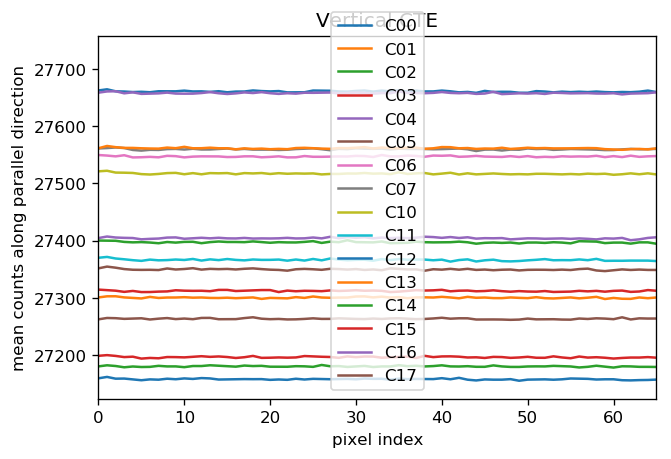

In [61]:
for channel_name, flips in flipXY.items():
    # get all the overscans in the same orientation and plot the mean along the y-axis
    arr = overscans3[channel_name].getArray() # pull out numpy array
    oscan = numpy.mean(arr)
    fx, fy = flips
    if fx:
        arr = numpy.flip(arr, axis=1)
    if fy:
        arr = numpy.flip(arr, axis=0)
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    mean = numpy.mean(arr, axis=0)
    plt.plot(mean, label=channel_name)

plt.title('Vertical CTE')
plt.xlabel('pixel index')
plt.ylabel('mean counts along parallel direction')
plt.xlim(0, 65)
#plt.ylim(-0.5, 0.5)
plt.legend()

In [65]:
arr = numpy.flip(arr, axis=0)
# aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
mn = numpy.mean(overscans3['C00'].getArray(), axis=0)

In [329]:
from astropy.io import fits
import os

In [351]:
base = '/project/bootcamp/repo_RTM-007/raw/7086'

min_avg = numpy.inf
max_avg = -numpy.inf

for f in os.listdir(base)[0:10]:
    val = fits.open(os.path.join(base, f))[1].header['AVERAGE']
    bias = fits.open(os.path.join(base, f))[1].header['AVGBIAS']
    exp = fits.open(os.path.join(base, f))[0].header['EXPTIME']
    if exp < 0.1:
        continue
    val = val - bias
    if val < min_avg:
        min_file = f
        min_avg = val
        min_exp = exp
    elif val > max_avg:
        max_file = f
        max_avg = val
        max_exp = exp

In [352]:
print(min_file, min_avg, min_exp)

00258339839-S02-det002.fits 119.28530640072131 0.115


In [353]:
print(max_file, max_avg, max_exp)

00258348982-S22-det008.fits 207813.95401587308 200.201
